# Final Pipeline

In [1]:
import os
import warnings
import dill
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Math, display
from sklearn.datasets import load_digits
from sklearn.manifold import Isomap
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from squlearn import Executor
from squlearn.encoding_circuit import RandomLayeredEncodingCircuit
from squlearn.observables import IsingHamiltonian
from squlearn.observables.observable_base import ObservableBase
from squlearn.optimizers import Adam
from squlearn.qnn import CrossEntropyLoss, QNNClassifier
from observables.utils import generate_measurement_circuits

In [2]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
%matplotlib inline

In [3]:
warnings.filterwarnings("ignore")

In [4]:
X, y = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=42, stratify=y)

### Pipeline

In [5]:
pipeline = make_pipeline(
    Isomap(
        n_components=5,
        max_iter=10_000,
    ),
    MinMaxScaler(
        feature_range=(-1, 1),
        clip=True,
    ),
    QNNClassifier(
        encoding_circuit=RandomLayeredEncodingCircuit(
            num_qubits=5,
            num_features=5,
            min_num_layers=3,
            max_num_layers=3,
            seed=12_08_1887,
        ),
        operator=len(np.unique(y)) * [IsingHamiltonian(num_qubits=5)],
        executor=Executor("qulacs"),
        loss=CrossEntropyLoss(),
        optimizer=Adam(),
    ))

### Training

In [6]:
checkpoint_filename = "checkpoints/trained_models/final_model.dill"
if os.path.isfile(checkpoint_filename):
    pipeline = dill.load(open(checkpoint_filename, "rb"))
else:
    pipeline.fit(X_train, y_train)
    dill.dump(pipeline, open(checkpoint_filename, "wb"))

### Evaluation

In [7]:
print(f"Train Accuracy:  {pipeline.score(X_train, y_train):.4f}")
print(f"Test Accuracy:   {pipeline.score(X_test, y_test):.4f}")

Train Accuracy:  0.9290
Test Accuracy:   0.9361


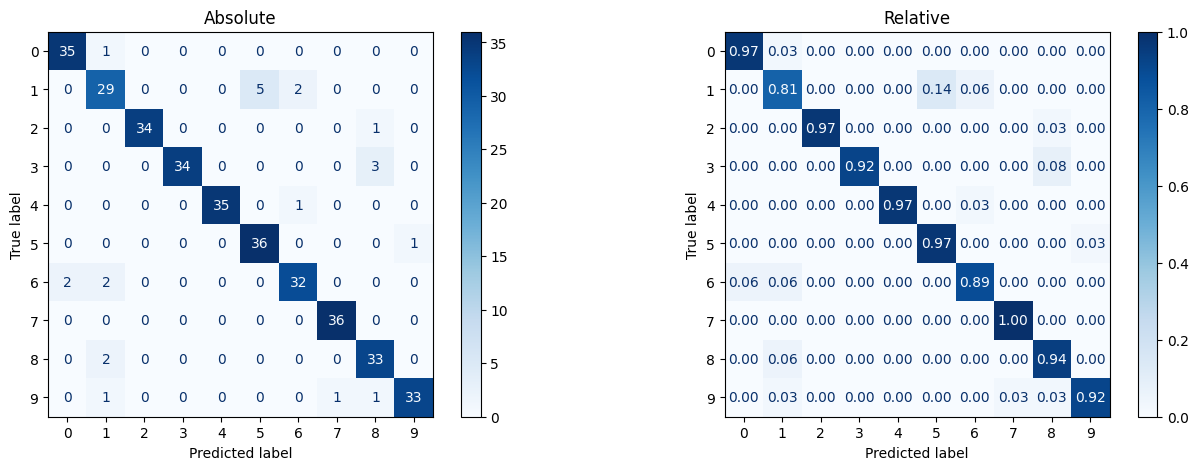

In [8]:
y_pred = pipeline.predict(X_test)

fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, y_pred),
    display_labels=pipeline.classes_,
).plot(
    cmap="Blues",
    ax=ax[0],
)
ax[0].set_title("Absolute")

ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, y_pred, normalize='true'),
    display_labels=pipeline.classes_,
).plot(
    cmap="Blues",
    ax=ax[1],
    values_format=".2f",
)
ax[1].set_title("Relative")

plt.show()

In [9]:
trained_classifier = pipeline.named_steps["qnnclassifier"]
print(f"Trained Parameters (Encoding Circuit): {len(trained_classifier.param)}")
print(f"Trained Parameters (Observable): {len(trained_classifier.param_op)}")

Trained Parameters (Encoding Circuit): 0
Trained Parameters (Observable): 160


In [10]:
def observable_to_latex(observable: ObservableBase, parameters: np.ndarray) -> Math:
    operator = observable.get_operator(parameters)
    return Math(" ".join([
        f"{coeff.real:+.2f} \, \\text{{{pauli}}}"
        for pauli, coeff in zip(operator.paulis, operator.coeffs)
    ]))

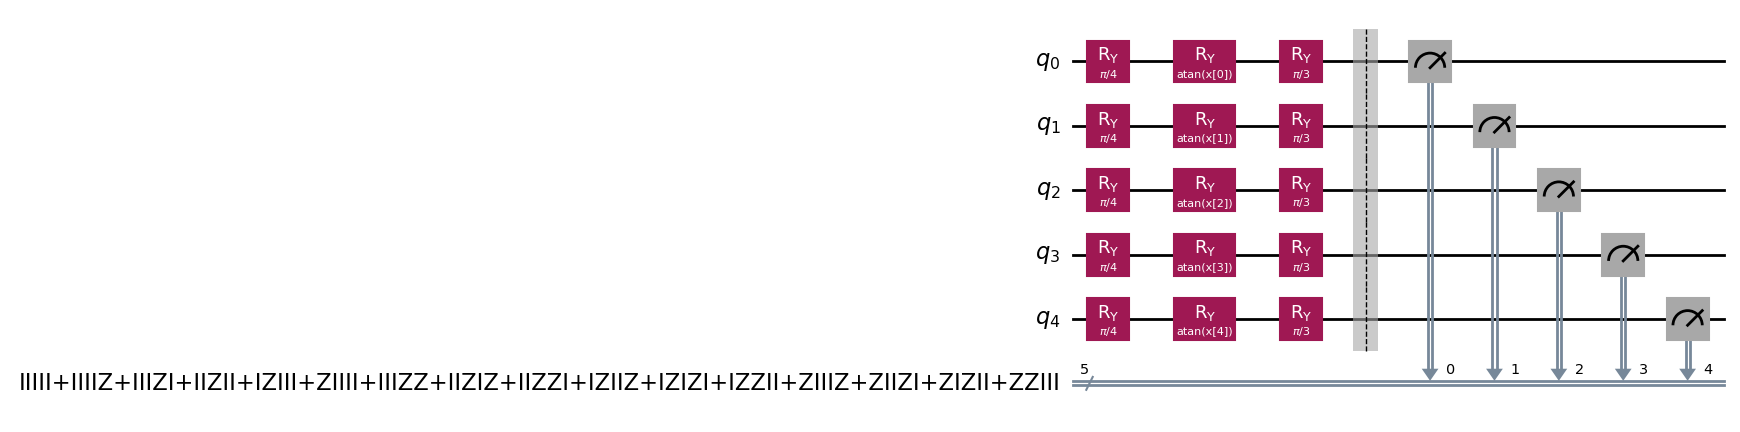

In [11]:
for measurement_circuit in generate_measurement_circuits(
        encoding_circuit=trained_classifier.encoding_circuit,
        observable=trained_classifier.operator[0],
        backend=None,
):
    measurement_circuit.draw("mpl")

In [12]:
for idx, observable in enumerate(trained_classifier.operator):
    parameters = trained_classifier.param_op[idx * 16: (idx + 1) * 16]
    display(observable_to_latex(observable, parameters))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>